<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

In [19]:
import math
N = 7
m = (N+1)/2
p = 0.8
u = sum([math.factorial(N)/(math.factorial(i)*math.factorial(N-i))*(p**i)*(((1-p)**(N-i))) for i in list(range(int(m), N+1))])
print(u*100)

96.66560000000001


#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/7nbdvV).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
- 80.00%
- 83.70%
- 96.66%

Теперь перейдем непосредственно к машинному обучению.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [21]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [22]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Рассмотрим типы считанных данных

In [23]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

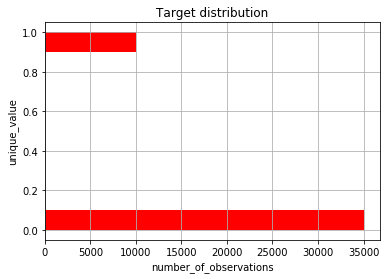

In [24]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [25]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [26]:
table = impute_nan_with_median(data)

Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [27]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Выведем версии основных библиотек – результат `GridSearchCV`, например, может отличаться в разных версиях `sklearn` даже при фиксированном `random_state`.

In [28]:
#!pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [29]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
scipy 0.19.1
pandas 0.20.3
matplotlib 2.1.0
sklearn 0.19.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.9.49-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 66d19eb67e3b0f34345b42d11a3e6c8e8fb24331


# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
- 655

In [30]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
#loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
#churn_calls= telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

# ставим seed для воспроизводимости результатов
np.random.seed(17)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
#loyal_mean_scores = [np.mean(sample) 
#                       for sample in get_bootstrap_samples(loyal_calls, 1000)]
#churn_mean_scores = [np.mean(sample) 
#                       for sample in get_bootstrap_samples(churn_calls, 1000)]

#  выводим интервальную оценку среднего
#print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.05))
#print("Service calls from churn:  mean interval",  stat_intervals(churn_mean_scores, 0.05))

bad_payers = (X['NumberOfTime30-59DaysPastDueNotWorse'] + X['NumberOfTimes90DaysLate'] + X['NumberOfTime30-59DaysPastDueNotWorse']) > 0
bad_payers = y == 1
bad_payer_salaries = X[bad_payers]['MonthlyIncome'].values
good_payer_salaries = X[~bad_payers]['MonthlyIncome'].values
print(len(bad_payer_salaries), len(good_payer_salaries))

bad_payer_salaries_means = [np.mean(sample) for sample in get_bootstrap_samples(bad_payer_salaries, 1000)]
good_payer_salaries_means = [np.mean(sample) for sample in get_bootstrap_samples(good_payer_salaries, 1000)]

stat_good_payer_salaries_means = stat_intervals(good_payer_salaries_means, 0.1)
stat_bad_payer_salaries_means = stat_intervals(bad_payer_salaries_means, 0.1)
print('stat_intervals for good_payer_salaries_means', stat_good_payer_salaries_means)
print('stat_intervals for bad_payer_salaries_means', stat_bad_payer_salaries_means)

print(int(stat_good_payer_salaries_means[0] - stat_bad_payer_salaries_means[1]))

10026 35037
stat_intervals for good_payer_salaries_means [ 6294.02952878  6517.48153952]
stat_intervals for bad_payer_salaries_means [ 5462.17301516  5641.20421404]
652


# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [32]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Перебирать будем вот такие значения гиперпараметров:

In [33]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [35]:
%%time
cv = GridSearchCV(dt, tree_params, scoring='roc_auc', cv=skf)
cv.fit(X, y);

CPU times: user 7.41 s, sys: 0 ns, total: 7.41 s
Wall time: 7.41 s


In [36]:
cv.best_score_

0.82030234762096355

In [37]:
print(cv.cv_results_['params'][cv.best_index_])
print('mean_test_score', cv.cv_results_['mean_test_score'][cv.best_index_]*100)
print('std_test_score', cv.cv_results_['std_test_score'][cv.best_index_]*100)
print('% =', cv.cv_results_['std_test_score'][cv.best_index_]/cv.cv_results_['mean_test_score'][cv.best_index_]*100)

{'max_depth': 7, 'max_features': 6}
mean_test_score 82.0302347621
std_test_score 0.275848355359
% = 0.336276442655


**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

**<font color='red'>Варианты ответа:</font>**
- 0.82, нет
- 0.84, нет
- 0.82, да
- 0.84, да

In [38]:
# Ваш код здесь

# Простая реализация случайного леса

**<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [39]:
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, max_features=10, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        
        for i in range(0, self.n_estimators-1):
            seed = self.random_state + i
            np.random.seed(seed)
            
            feat_indicies = np.random.choice(len(X.columns), self.max_features, replace=False)
            
            row_indices = np.random.randint(0, X.shape[0], (X.shape[0], 1)).flatten()
            
            X_bootstrapped = X.iloc[row_indices, feat_indicies]
            y_bootstrapped = y.iloc[row_indices]        
            
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=seed)            
            
            tree.fit(X_bootstrapped, y_bootstrapped)
            
            self.trees.append(tree)
            self.feat_ids_by_tree.append(feat_indicies)
        return self
        
    
    def predict_proba(self, X):
        y_pred = np.zeros((X.shape[0], 2))
        for i, tree in enumerate(self.trees):
            X_tmp = X.iloc[:, self.feat_ids_by_tree[i]]
            y_pred += tree.predict_proba(X_tmp)
        return y_pred/len(self.feat_ids_by_tree)


In [40]:
rfc = RandomForestClassifierCustom(max_features=6, max_depth=7)
float(np.round(np.mean(cross_val_score(rfc, X, y, cv=skf, scoring='roc_auc')), 3))

0.832

**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_features=6, max_depth=7, n_jobs=1, random_state=17)
np.mean(cross_val_score(rf, X, y, cv=skf, scoring='roc_auc'))

0.830519720262196

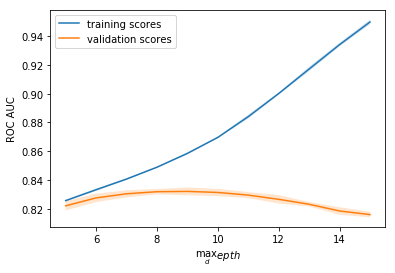

In [44]:
from sklearn.model_selection import validation_curve

max_depths = range(5, 16)

train_scores, valid_scores = validation_curve(rf, X, y, "max_depth", max_depths, cv=skf, scoring='roc_auc')

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(max_depths, train_scores, label='training scores')
plot_with_err(max_depths, valid_scores, label='validation scores')
plt.xlabel(r'$\max_depth$')
plt.ylabel('ROC AUC')
plt.legend();

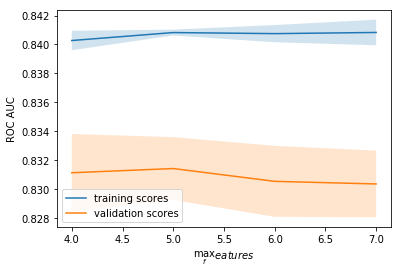

In [46]:
from sklearn.model_selection import validation_curve

max_features_values = range(4, 8)

train_scores, valid_scores = validation_curve(rf, X, y, "max_features", max_features_values, cv=skf, scoring='roc_auc')

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(max_features_values, train_scores, label='training scores')
plot_with_err(max_features_values, valid_scores, label='validation scores')
plt.xlabel(r'$\max_features$')
plt.ylabel('ROC AUC')
plt.legend();

# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые значения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
- `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [202]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [203]:
%%time

cv = GridSearchCV(RandomForestClassifier(random_state=17), tree_params, scoring='roc_auc', cv=skf)
cv.fit(X, y);

print(cv.cv_results_['params'][cv.best_index_])
print('mean_test_score', cv.cv_results_['mean_test_score'][cv.best_index_]*100)
print('std_test_score', cv.cv_results_['std_test_score'][cv.best_index_]*100)
print('% =', cv.cv_results_['std_test_score'][cv.best_index_]/cv.cv_results_['mean_test_score'][cv.best_index_]*100)

{'max_features': 4, 'max_depth': 8}
mean_test_score 83.2868063141
std_test_score 0.241530080626
% = 0.289998009666
CPU times: user 39.8 s, sys: 0 ns, total: 39.8 s
Wall time: 39.8 s


# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778
- 0.788
- 0.798
- 0.808

In [204]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [206]:
%%time

cv = GridSearchCV(logit_pipe, logit_pipe_params, scoring='roc_auc', cv=skf)
cv.fit(X, y);

print(cv.cv_results_['params'][cv.best_index_])
print('mean_test_score', cv.cv_results_['mean_test_score'][cv.best_index_])
print('std_test_score', cv.cv_results_['std_test_score'][cv.best_index_])
print('% =', cv.cv_results_['std_test_score'][cv.best_index_]/cv.cv_results_['mean_test_score'][cv.best_index_]*100)

{'logit__C': 100000.0}
mean_test_score 0.787862675731
std_test_score 0.00485314603194
% = 0.615988824123
CPU times: user 9.5 s, sys: 18.7 s, total: 28.2 s
Wall time: 7.45 s


# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://yadi.sk/d/pHZlDkg-3NSUQW).

In [23]:
# Загрузим данные
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [25]:
# Ваш код здесь

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [26]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [27]:
# Ваш код здесь